In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import re
import seaborn as sns
from sklearn.cluster import KMeans
import pyodbc

In [67]:
data_r = pd.read_csv("RFM R.txt", sep='\t', names=['id', 'rfm_r'])
data_f = pd.read_csv("RFM F.txt", sep='\t', names=['id', 'rfm_f'])
data_m = pd.read_csv("RFM M.txt", sep='\t', names=['id', 'rfm_m'])

In [ ]:
def to_float(row):
    row['rfm_m'] = re.sub(r',', r'.', row['rfm_m'])
    return row
    
data = data.apply(to_float, axis=1)

In [160]:
cnxn = pyodbc.connect(driver='{SQL Server}',
                      server='aurora',
                      database='hoff')

In [158]:
def get_rfm_query(typ, count=1000):
    query = """
            select top({count}) c.Id CustId
                ,{field}

                from directcrm.Customers c
                    join directcrm.CustomerActions ca on c.Id = ca.CustomerId
                    join directcrm.RetailOrders ro on ca.Id = ro.FirstCustomerActionId
                    join directcrm.RetailOrderHistory roh on ro.Id = roh.OrderId
                    join directcrm.RetailPurchaseHistory rph on roh.id = rph.OrderHistoryItemId
                    join directcrm.RetailPurchaseStatuses rps on rph.StatusId = rps.Id

                where rps.CategorySystemName not in ('Returned','Cancelled','InCart') and roh.IsCurrentOtherwiseNull = 1

                group by c.Id

                order by c.Id
            """
    
    fields = {'r': 'DateDiff(hh, Max(ca.DateTimeUtc), GetDate()) Recency_hours',
              'f': 'Count(ca.Id) CountActions',
              'm': 'Sum(roh.EffectivePayedAmount) Amount'}
    
    query = query.format(count=count, field=fields[typ])
    return query

In [166]:
def get_rfm_data(cnxn, typ, count=1000):
    cursor = cnxn.cursor()
    cursor.execute(get_rfm_query(typ, count))
    rows = list(map(lambda t: [t[0], t[1]], cursor.fetchall()))
    df = pd.DataFrame(rows, columns=['id', 'rfm_{}'.format(typ)])
    return df

In [167]:
count = 100
data_r = get_rfm_data(cnxn, 'r', count=count)
data_f = get_rfm_data(cnxn, 'f', count=count)
data_m = get_rfm_data(cnxn, 'm', count=count)

In [168]:
if sum (data_r.id != data_f.id) or sum(data_r.id != data_m.id):
    raise RuntimeError("Не совпадают индексы")
else:
    data = pd.concat([data_r, data_f.drop('id', axis=1), data_m.drop('id', axis=1)], axis=1)

In [175]:
data.dtypes

id         int64
rfm_r      int64
rfm_f      int64
rfm_m    float64
dtype: object

In [174]:
data['rfm_m'] = data['rfm_m'].astype(float)

In [176]:
data.head()

,id,rfm_r,rfm_f,rfm_m
0,5,33597,2,21960.0
1,149,33741,3,26750.0
2,221,21260,6,80022.0
3,293,27116,3,95950.0
4,294,27788,5,44380.0


In [178]:
def reduce_tails(data, min_q=0.025, max_q=0.975):
    filtered_data = data[(data['rfm_r'] >= data['rfm_r'].quantile(min_q)) &
                         (data['rfm_r'] <= data['rfm_r'].quantile(max_q)) &
                         (data['rfm_f'] >= data['rfm_f'].quantile(min_q)) &
                         (data['rfm_f'] <= data['rfm_f'].quantile(max_q)) &
                         (data['rfm_m'] >= data['rfm_m'].quantile(min_q)) &
                         (data['rfm_m'] <= data['rfm_m'].quantile(max_q))]
    return filtered_data

In [179]:
raw_data = data.copy()

In [186]:
def draw_3d_plot(data, labels=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.set_xlabel("R")
    ax.set_ylabel("F")
    ax.set_zlabel("M")
    
    if labels is None:
        x = list(data['rfm_r'])
        y = list(data['rfm_f'])
        z = list(data['rfm_m'])
        ax.scatter(x, y, z)
        
    else:
        for n in np.unique(labels):
            indices = kmeans.labels_ == n
            x = list(data.loc[indices, 'rfm_r'])
            y = list(data.loc[indices, 'rfm_f'])
            z = list(data.loc[indices, 'rfm_m'])

            c = [[n * 2 % 256, n * 5 % 256, n * 13 % 256]]
            ax.scatter(x, y, z)

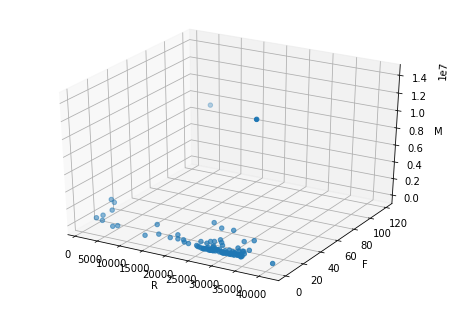

In [188]:
draw_3d_plot(data)

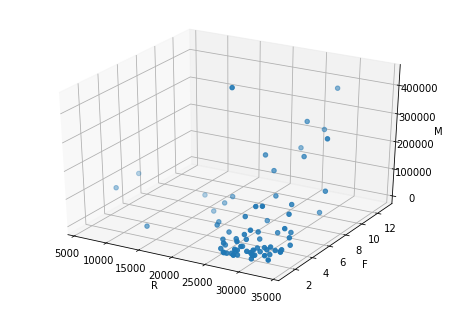

In [190]:
draw_3d_plot(reduce_tails(data, 0.05, 0.90))

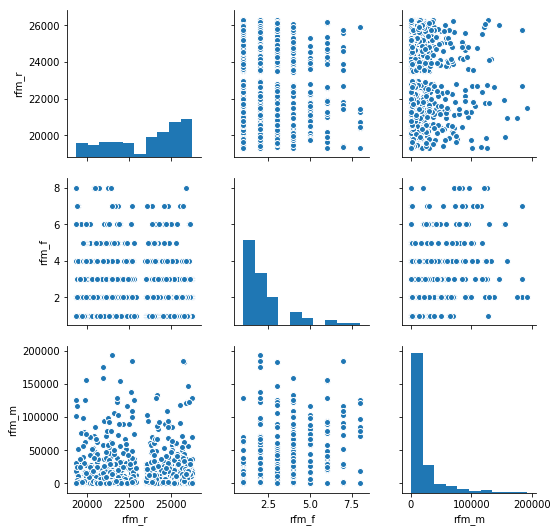

In [97]:
sns.pairplot(filtered_data.drop('id', axis=1))

In [126]:
data = filtered_data
X = data[['rfm_r', 'rfm_f', 'rfm_m']]

In [127]:
n_clusters = 10

In [128]:
kmeans = KMeans(n_clusters=n_clusters, random_state=17).fit(X)

In [129]:
kmeans.labels_
kmeans.cluster_centers_
kmeans.inertia_

12762550648.969343

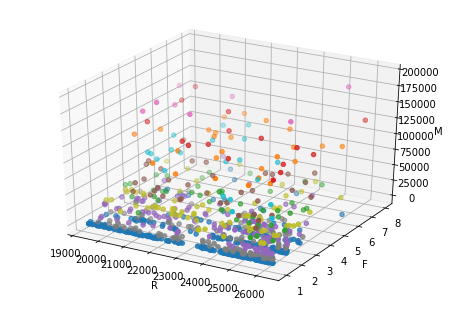

In [130]:
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("R")
ax.set_ylabel("F")
ax.set_zlabel("M")


for n in range(n_clusters):
    indices = kmeans.labels_ == n
    x = list(data.loc[indices, 'rfm_r'])
    y = list(data.loc[indices, 'rfm_f'])
    z = list(data.loc[indices, 'rfm_m'])
    
    c = [[n * 2 % 256, n * 5 % 256, n * 13 % 256]]
    ax.scatter(x, y, z)
    

In [185]:
labels = kmeans.labels_
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])